## 1. 캐글 설정 및 데이터셋 다운로드

In [2]:
%cd /content/drive/MyDrive/2024_Prometheus_Hackathon/
%ls

/content/drive/MyDrive/2024_Prometheus_Hackathon
eda.ipynb  food_classification_model.pth  food_dataset/  kaggle.json  submission.csv


In [4]:
!pip install kaggle

In [21]:
%cd '/root/.kaggle'

/root/.kaggle


In [22]:
%ls

In [23]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"suminshim04","key":"9cdf7da455ccfccfeee77eb95415e93b"}'}

In [15]:
!kaggle competitions download -c 2024-1-prometheus-hackathon

100% 5.34G/5.35G [01:18<00:00, 163MB/s]
100% 5.35G/5.35G [01:19<00:00, 72.7MB/s]


In [26]:
!unzip /root/.kaggle/2024-1-prometheus-hackathon.zip

[Errno 20] Not a directory: '/root/.kaggle/2024-1-prometheus-hackathon.zip'
/root/.kaggle
Archive:  /root/.kaggle/2024-1-prometheus-hackathon.zip
  inflating: food_dataset/test/test_000.png  
  inflating: food_dataset/test/test_001.png  
  inflating: food_dataset/test/test_002.png  
  inflating: food_dataset/test/test_003.png  
  inflating: food_dataset/test/test_004.png  
  inflating: food_dataset/test/test_005.png  
  inflating: food_dataset/test/test_006.png  
  inflating: food_dataset/test/test_007.png  
  inflating: food_dataset/test/test_008.png  
  inflating: food_dataset/test/test_009.png  
  inflating: food_dataset/test/test_010.png  
  inflating: food_dataset/test/test_011.png  
  inflating: food_dataset/test/test_012.png  
  inflating: food_dataset/test/test_013.png  
  inflating: food_dataset/test/test_014.png  
  inflating: food_dataset/test/test_015.png  
  inflating: food_dataset/test/test_016.png  
  inflating: food_dataset/test/test_017.png  
  inflating: food_dataset/

## 2. EDA

In [16]:
!pip install matplotlib
!pip install seaborn

In [7]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import seaborn as sns
import pandas as pd


In [27]:
%ls

2024-1-prometheus-hackathon.zip  food_dataset/  kaggle.json


In [28]:
%mv food_dataset /content/drive/MyDrive/2024_Prometheus_Hackathon/

In [4]:
%cd /content/drive/MyDrive/2024_Prometheus_Hackathon/

/content/drive/MyDrive/2024_Prometheus_Hackathon


In [5]:
%ls

eda.ipynb  food_dataset/  kaggle.json


In [33]:
food_dataset_train_path = './food_dataset/train'
food_dataset_test_path = './food_dataset/test'

In [34]:
# 각 음식 이미지 개수 세기
food_image_counts = {}
for food_folder in os.listdir(food_dataset_train_path):
    food_folder_path = os.path.join(food_dataset_train_path, food_folder)

    if os.path.isdir(food_folder_path):
        num_images = len([file for file in os.listdir(food_folder_path) if os.path.isfile(os.path.join(food_folder_path, file))])

        food_image_counts[food_folder] = num_images

In [35]:
for food, count in food_image_counts.items():
    print(f"{food}: {count} images")

kimchi_stew: 150 images
korean_pancake: 150 images
lasana: 149 images
lobster: 148 images
madeleine: 150 images
mapa_tofu: 150 images
milfeuille: 150 images
muffin: 150 images
naan: 150 images
nachos: 148 images
nasi_goreng: 150 images
omelet: 150 images
onigiri: 148 images
pad_thai: 150 images
paea: 150 images
pancake: 148 images
pasta: 147 images
pie: 148 images
pizza: 150 images


다 비슷함.

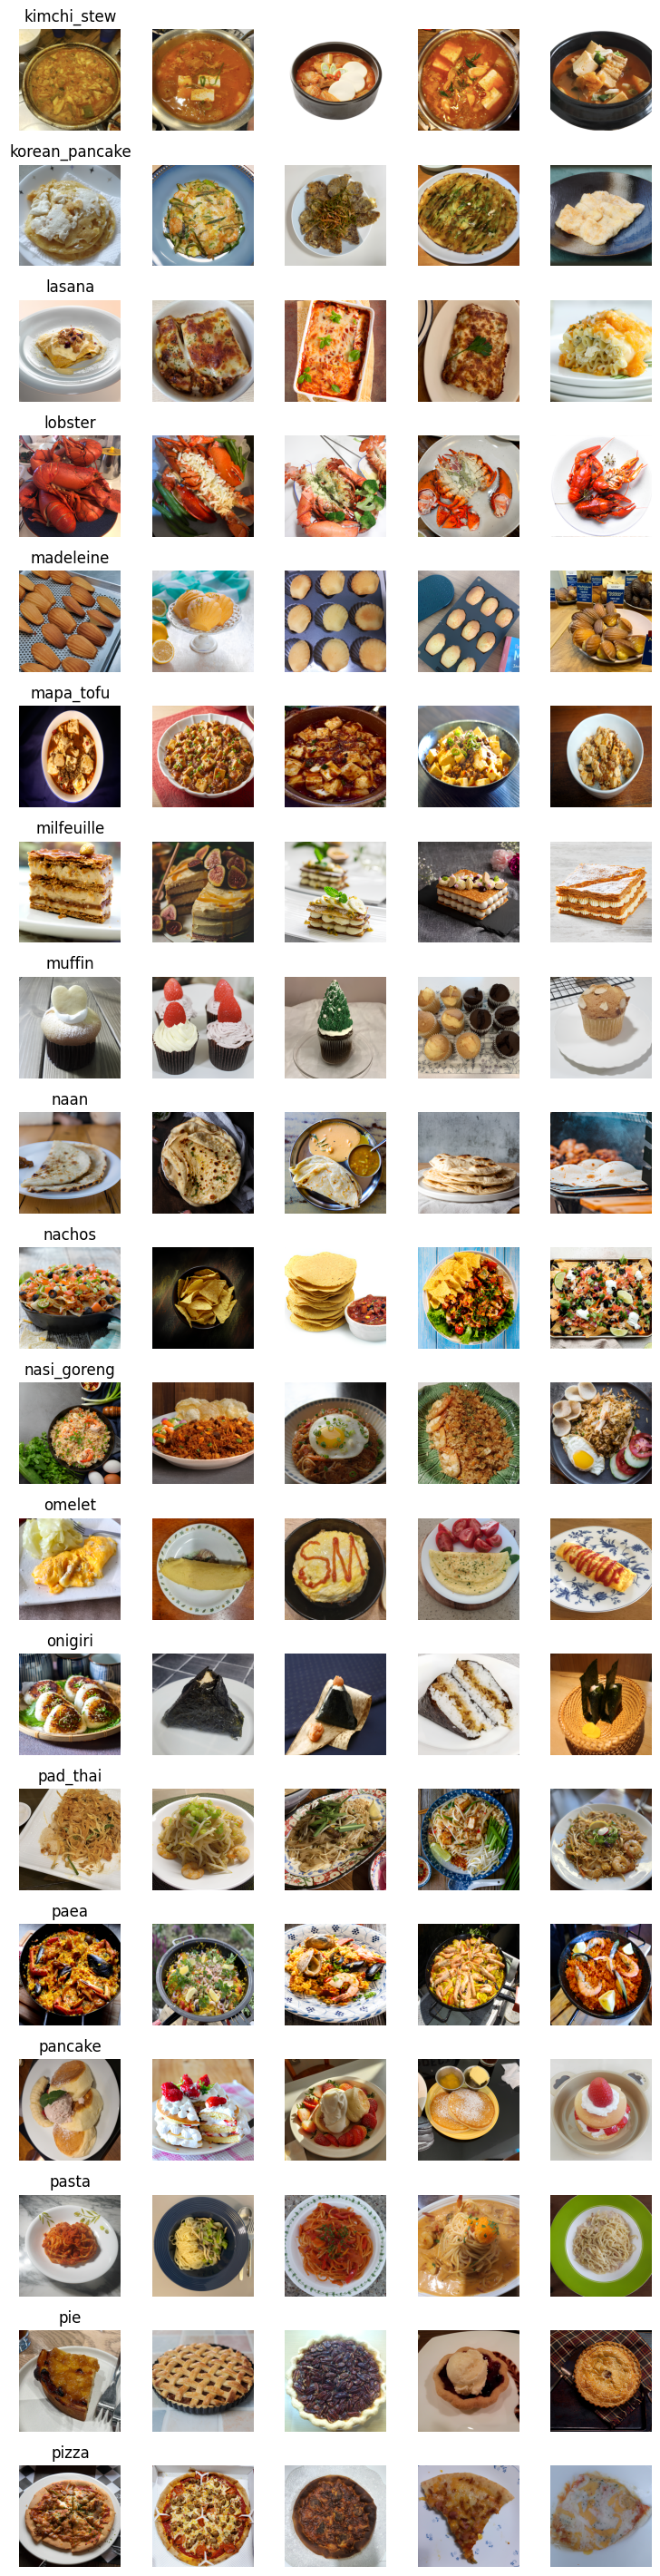

In [36]:
def display_sample_images(food_dataset_train_path, num_samples=5):
    food_folders = [f for f in os.listdir(food_dataset_train_path) if os.path.isdir(os.path.join(food_dataset_train_path, f))]

    fig, axs = plt.subplots(len(food_folders), num_samples,  figsize=(num_samples*1.5, len(food_folders)*1.5))

    for i, food_folder in enumerate(food_folders):
        food_folder_path = os.path.join(food_dataset_train_path, food_folder)

        image_files = [f for f in os.listdir(food_folder_path) if os.path.isfile(os.path.join(food_folder_path, f))]

        sample_images = random.sample(image_files, min(num_samples, len(image_files)))

        for j, image_file in enumerate(sample_images):
            image_path = os.path.join(food_folder_path, image_file)

            try:
                img = mpimg.imread(image_path)
                axs[i, j].imshow(img)
                axs[i, j].axis('off')  # Hide the axis
                if j == 0:
                    axs[i, j].set_title(food_folder, fontsize=12)
            except (SyntaxError, IOError):
                print(f"Cannot read image {image_path}. Skipping.")

    plt.tight_layout()
    plt.show()

display_sample_images(food_dataset_train_path)


이미지 사이즈 확인하기

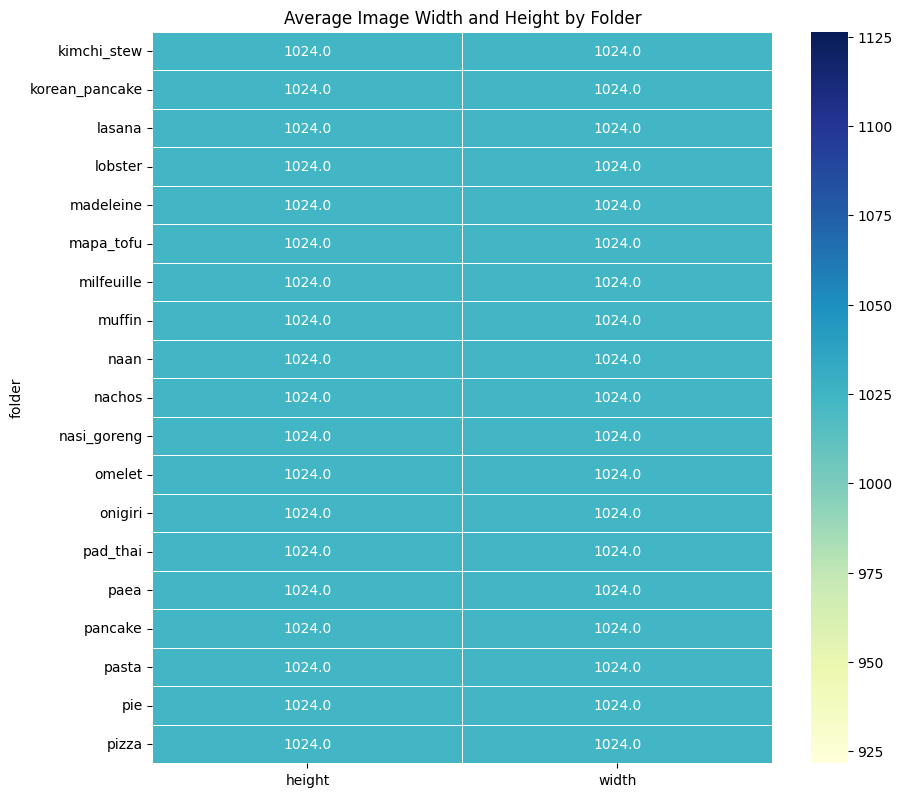

In [37]:
def collect_image_sizes(food_dataset_path):
    image_sizes = {'folder': [], 'width': [], 'height': []}

    food_folders = [f for f in os.listdir(food_dataset_path) if os.path.isdir(os.path.join(food_dataset_path, f))]

    for food_folder in food_folders:
        # Get the path to the current food folder
        food_folder_path = os.path.join(food_dataset_path, food_folder)

        # Get the list of image files in the current food folder
        image_files = [f for f in os.listdir(food_folder_path) if os.path.isfile(os.path.join(food_folder_path, f))]

        for image_file in image_files:
            image_path = os.path.join(food_folder_path, image_file)

            try:
                with Image.open(image_path) as img:
                    width, height = img.size
                    image_sizes['folder'].append(food_folder)
                    image_sizes['width'].append(width)
                    image_sizes['height'].append(height)
            except (SyntaxError, IOError):
                print(f"Cannot read image {image_path}. Skipping.")

    return pd.DataFrame(image_sizes)

def plot_image_sizes(image_sizes_df):
    pivot_table = image_sizes_df.pivot_table(index='folder', values=['width', 'height'], aggfunc='mean')

    plt.figure(figsize=(10, len(pivot_table) * 0.5))
    sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5)
    plt.title("Average Image Width and Height by Folder")
    plt.show()


image_sizes_df = collect_image_sizes(food_dataset_train_path)

# Plot image sizes
plot_image_sizes(image_sizes_df)


이것도 똑같네? -> 1024x1024

In [6]:
import numpy as np
img = plt.imread('./food_dataset/train/korean_pancake/000.png')
dims = np.shape(img)
matrix = np.reshape(img, (dims[0] * dims[1], dims[2]))
print(np.shape(matrix))

(1048576, 3)


Image shape ->  (1024, 1024)
Color channels ->  3
Min color depth : 0.0, Max color depth 1.0


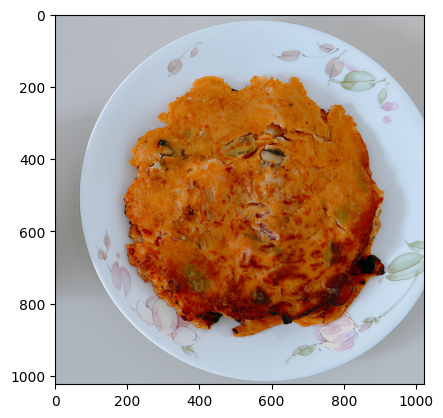

In [7]:
plt.imshow(img)
print("Image shape -> ",dims[:2])
print("Color channels -> ",dims[2])
print("Min color depth : {}, Max color depth {}".format(np.min(img),np.max(img)))

## 3. 학습시키기

In [8]:
!pip install torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [9]:
!pip install torch

In [14]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder

# Define the path
food_dataset_path = './food_dataset'

# transforms for the training set
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# training dataset
image_datasets = {'train': ImageFolder(os.path.join(food_dataset_path, 'train'), data_transforms['train'])}
dataloaders = {'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4)}
dataset_sizes = {'train': len(image_datasets['train'])}
class_names = image_datasets['train'].classes

# Load a pre-trained model and modify the final layer
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

# loss, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training
def train_model(model, criterion, optimizer, num_epochs=5):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        model.train()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward + optimize only if in training phase
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes['train']
        epoch_acc = running_corrects.double() / dataset_sizes['train']

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = model.state_dict()

    print(f'Best Train Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device) # gpu 사용하고 있는지 확인 (cuda:0)

# Train and save the model
model = model.to(device)
model = train_model(model, criterion, optimizer, num_epochs=3)
torch.save(model.state_dict(), 'food_classification_model.pth')



cuda:0
Epoch 0/2
----------
Train Loss: 2.2630 Acc: 0.4245
Epoch 1/2
----------
Train Loss: 1.0150 Acc: 0.7585
Epoch 2/2
----------
Train Loss: 0.6828 Acc: 0.8145
Best Train Acc: 0.814528


## Inference

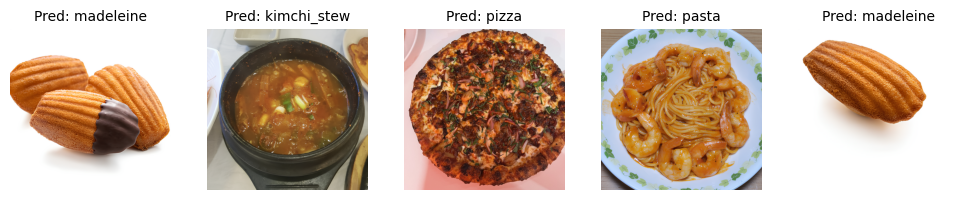

In [15]:
import os
import random
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the trained model for inference
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model.load_state_dict(torch.load('food_classification_model.pth'))
model.eval()
model = model.to(device)

# Define transforms for the test set
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Inference
def predict_image(image_path, model, preprocess):
    input_image = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    with torch.no_grad():
        output = model(input_batch.to(device))

    # Get the predicted class
    _, predicted_idx = torch.max(output, 1)
    return class_names[predicted_idx.item()]

def display_predictions(test_folder_path, model, preprocess, num_samples=5):
    image_files = [f for f in os.listdir(test_folder_path) if os.path.isfile(os.path.join(test_folder_path, f))]

    # sample image 선택
    sample_images = random.sample(image_files, min(num_samples, len(image_files)))

    # 시각화 부분
    fig, axs = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))

    for j, image_file in enumerate(sample_images):
        image_path = os.path.join(test_folder_path, image_file)

        try:
            # Perform prediction
            predicted_class = predict_image(image_path, model, preprocess)

            # Load and display the image
            img = Image.open(image_path)
            axs[j].imshow(img)
            axs[j].axis('off')
            axs[j].set_title(f"Pred: {predicted_class}", fontsize=10)
        except Exception as e:
            print(f"Cannot process image {image_path}. Skipping. Error: {e}")

    plt.tight_layout()
    plt.show()

# Display predictions
test_folder_path = os.path.join(food_dataset_path, 'test')
display_predictions(test_folder_path, model, preprocess)


In [10]:
import os
import csv
import torch
from torchvision import models, transforms
from PIL import Image
import pandas as pd

# Define the class to label mapping
class_to_label = {"kimchi_stew": 0, "korean_pancake": 1, "lasana": 2, "lobster": 3, "madeleine": 4, "mapa_tofu": 5, "milfeuille": 6, "muffin":7, "naan": 8, "nachos": 9, "nasi_goreng":10, "omelet": 11, "onigiri": 12, "pad_thai":13, "paea": 14, "pancake": 15, "pasta": 16, "pie": 17, "pizza": 18}
label_to_class = {v: k for k, v in class_to_label.items()}
class_names = list(class_to_label.keys())

# Load the trained model for inference
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model.load_state_dict(torch.load('food_classification_model.pth'))
model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define transforms for the test set
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Inference function
def predict_image(image_path, model, preprocess):
    input_image = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    with torch.no_grad():
        output = model(input_batch.to(device))

    # Get the predicted class
    _, predicted_idx = torch.max(output, 1)
    return predicted_idx.item()

# DataFrame -> CSV
def generate_predictions_dataframe(test_folder_path, model, preprocess, output_csv):
    image_files = sorted([f for f in os.listdir(test_folder_path) if os.path.isfile(os.path.join(test_folder_path, f))])

    predictions = []

    for image_file in image_files:
        image_path = os.path.join(test_folder_path, image_file)
        try:
            # prediction
            predicted_idx = predict_image(image_path, model, preprocess)
            predicted_label = class_to_label[label_to_class[predicted_idx]]

            print(image_path, 'predicted_class', predicted_label)

            # Append prediction
            predictions.append([image_file, predicted_label])
        except Exception as e:
            print(f"Cannot process image {image_path}. Skipping. Error: {e}")

    # Create DataFrame
    df = pd.DataFrame(predictions, columns=['ID', 'Prediction'])

    # Save DataFrame to CSV without index
    df.to_csv(output_csv, index=False)

# Define paths
food_dataset_path = './food_dataset'
test_folder_path = os.path.join(food_dataset_path, 'test')
output_csv = 'submission.csv'

generate_predictions_dataframe(test_folder_path, model, preprocess, output_csv)

# Display the first 5 rows of the CSV file to verify
submission_df = pd.read_csv(output_csv)
print(submission_df.head())


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


./food_dataset/test/test_000.png predicted_class 6
./food_dataset/test/test_001.png predicted_class 6
./food_dataset/test/test_002.png predicted_class 12
./food_dataset/test/test_003.png predicted_class 5
./food_dataset/test/test_004.png predicted_class 8
./food_dataset/test/test_005.png predicted_class 1
./food_dataset/test/test_006.png predicted_class 6
./food_dataset/test/test_007.png predicted_class 7
./food_dataset/test/test_008.png predicted_class 5
./food_dataset/test/test_009.png predicted_class 1
./food_dataset/test/test_010.png predicted_class 5
./food_dataset/test/test_011.png predicted_class 11
./food_dataset/test/test_012.png predicted_class 11
./food_dataset/test/test_013.png predicted_class 6
./food_dataset/test/test_014.png predicted_class 3
./food_dataset/test/test_015.png predicted_class 8
./food_dataset/test/test_016.png predicted_class 8
./food_dataset/test/test_017.png predicted_class 2
./food_dataset/test/test_018.png predicted_class 17
./food_dataset/test/test_01

## 제출하기

In [3]:
%cd /content/drive/MyDrive/2024_Prometheus_Hackathon/

/content/drive/MyDrive/2024_Prometheus_Hackathon


In [40]:
%ls

eda.ipynb  food_classification_model.pth  food_dataset/  kaggle.json  submission.csv


In [47]:
!kaggle competitions submit -c 2024-1-prometheus-hackathon -f submission.csv -m "first submission"

100% 15.3k/15.3k [00:00<00:00, 22.2kB/s]
Successfully submitted to 2024-1 PROMETHEUS HACKATHON

In [2]:
%ls

drive/  sample_data/


In [46]:
import pandas as pd

# Define the path to the CSV file
csv_file_path = 'submission.csv'

# Read the CSV file
submission_df = pd.read_csv(csv_file_path)

# Print the first 5 rows
print(submission_df.head())


             Id  Prediction
0  test_000.png           6
1  test_001.png           6
2  test_002.png          12
3  test_003.png           5
4  test_004.png           8
